In [ ]:
# Importing functions and classes we'll use

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings
from warnings import filterwarnings
import keras
import sys
import scipy.stats
import json
import numpy.fft
import time
from decimal import Decimal
import math
import seaborn as sns
%matplotlib inline

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(1234)

In [ ]:
df = pd.read_excel('/content/sample_data/new_dataset.xlsx')
node1_delay = df[['node1_delay']]

dataset = node1_delay.values

# MA Filter Implementation

In [ ]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real

        # Find autocorrelation peaks
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))

def moving_average(data, _range):
    ret = np.cumsum(data)
    ret[_range:] = ret[int(_range):] - ret[:-int(_range)]
    return ret[int(_range) - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, int(_range))[::int(slide)]
    return list(ret)

def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

# Algorithm to transfer data in tabular format

In [ ]:
def create_multistep_dataset(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            X.append(x_input)
            y.append(data[in_end:out_end])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# ESN Model Library

In [ ]:
def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

# First Dataset : Node1 Delay

### ARIMA Model

In [ ]:
# one-step sarima forecast
def sarima_forecast(history, config, window_size):
  order, sorder, trend = config
  # define model
  model = SARIMAX(history[-window_size:], order=order, seasonal_order=sorder, trend=trend,
                  enforce_stationarity=False, enforce_invertibility=False)

  # Record the starting time to train ARIMA Model
  training_start_time = time.time()

  # fit model
  model_fit = model.fit(disp=False)

  # Record the ending time of Training
  training_end_time = time.time()
  training_elapsed_time = training_end_time - training_start_time


  # Record the starting time to generate predictions
  predictions_start_time = time.time()

  # make one step forecast
  yhat = model_fit.predict(len(history[-window_size:]), len(history[-window_size:]))

  # Record the ending time of Generating predictions
  predictions_end_time = time.time()
  predictions_elapsed_time = predictions_end_time - predictions_start_time

  return yhat[0], training_elapsed_time, predictions_elapsed_time

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

In [ ]:
# mean absolute error or mae
def measure_mae(actual, predicted):
  return mean_absolute_error(actual, predicted)

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, window_size):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  # error = measure_mae(test, predictions)
  return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, window_size, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg, window_size)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg, window_size)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f, window size : %d' % (key, result, window_size))
  return (key, result)

In [ ]:
# Define Dataset

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.02171
ARIMA Test MAE : 0.01775
ARIMA Elapsed Time To train the model : 295.24045 seconds
ARIMA Elapsed Time To generate Predictions : 6.07866 seconds
ARIMA Mean Time To train the model : 0.14762 seconds
ARIMA Mean Time To generate Predictions : 0.00304 seconds


### GRU Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 4ms/step - loss: 0.0030
Epoch 2/82
407/407 [==============================] - 2s 6ms/step - loss: 7.8969e-04
Epoch 3/82
407/407 [==============================] - 2s 4ms/step - loss: 6.2134e-04
Epoch 4/82
407/407 [==============================] - 2s 4ms/step - loss: 5.4159e-04
Epoch 5/82
407/407 [==============================] - 2s 4ms/step - loss: 5.2726e-04
Epoch 6/82
407/407 [==============================] - 2s 4ms/step - loss: 5.1277e-04
Epoch 7/82
407/407 [==============================] - 2s 4ms/step - loss: 4.6718e-04
Epoch 8/82
407/407 [==============================] - 2s 4ms/step - loss: 4.6773e-04
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 4.2902e-04
Epoch 10/82
407/407 [==============================] - 2s 4ms/step - loss: 4.3540e-04
Epoch 11/82
407/407 [==============================] - 2s 4ms/step - loss: 4.1379e-04
Epoch 12/82
407/407 [==============================] - 2s 4ms/step - loss: 4.0

### RNN Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 3s 5ms/step - loss: 0.0023
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 8.3176e-04
Epoch 3/82
407/407 [==============================] - 3s 8ms/step - loss: 6.5328e-04
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 5.7996e-04
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 5.6735e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 5.1749e-04
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 5.1597e-04
Epoch 8/82
407/407 [==============================] - 3s 6ms/step - loss: 4.8919e-04
Epoch 9/82
407/407 [==============================] - 3s 6ms/step - loss: 4.6567e-04
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 4.5891e-04
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 4.4450e-04
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 4.4

### ESN Model

In [ ]:
pip install -q optuna

In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
# Finding best params

node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))


# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(temp_train, look_back, 1)
    validX, validY = create_multistep_dataset(valid, look_back, 1)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], validX.shape[1]))

    # Build and fit the ESN model

    model = ESN(n_inputs = look_back,
                n_outputs = 1,
                n_reservoir = n_reservoir,
                sparsity=sparsity,
                random_state=1234,
                spectral_radius=spectral_radius,
                noise = noise,
                teacher_scaling = 10)

    # Train and test our model
    pred_train = model.fit(trainX, trainY)
    predictions = model.predict(validX)
    predictions = np.array(predictions)

    # Evaluate the model on the validation set
    val_loss = np.sqrt(mean_squared_error(predictions, validY))

    return val_loss

# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("ESN HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-08-28 16:00:21,637] A new study created in memory with name: no-name-2b59b04e-409a-486c-939e-8389e0af911f


Window Size:  10
17991 16192 1799 2000


[I 2023-08-28 16:00:48,802] Trial 0 finished with value: 0.016316154867311607 and parameters: {'n_reservoir': 774, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.004, 'look_back': 302}. Best is trial 0 with value: 0.016316154867311607.
[I 2023-08-28 16:01:00,613] Trial 1 finished with value: 0.01744803576345066 and parameters: {'n_reservoir': 543, 'sparsity': 0.5, 'spectral_radius': 1.1, 'noise': 0.002, 'look_back': 50}. Best is trial 0 with value: 0.016316154867311607.
[I 2023-08-28 16:01:08,293] Trial 2 finished with value: 0.017342060107036903 and parameters: {'n_reservoir': 494, 'sparsity': 0.1, 'spectral_radius': 0.1, 'noise': 0.006, 'look_back': 32}. Best is trial 0 with value: 0.016316154867311607.
[I 2023-08-28 16:01:32,751] Trial 3 finished with value: 0.016279930891696288 and parameters: {'n_reservoir': 963, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.008, 'look_back': 443}. Best is trial 3 with value: 0.016279930891696288.
[I 2023-08-28 16:01:37,789] Trial 4 f

done
ESN HyperParameters Tuning Elapsed Time : 439.59206 seconds
Best Parameters:  {'n_reservoir': 33, 'sparsity': 0.3, 'spectral_radius': 1.1, 'noise': 0.004, 'look_back': 261}
Best Loss:  0.01542489762734059


In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

harvesting states...
fitting...
training error:
0.015327274933862964
ESN Model Training Elapsed Time : 2.83301 seconds
ESN Model Generate predictions Elapsed Time : 0.14184 seconds
ESN Test RMSE : 0.01583
ESN Test MAE : 0.01362


## Node2 Delay

### ARIMA Model

In [ ]:
# Define Dataset

node1_delay = df[['node2_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  9
17992 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.00831
ARIMA Test MAE : 0.00677
ARIMA Elapsed Time To train the model : 331.13528 seconds
ARIMA Elapsed Time To generate Predictions : 6.20659 seconds
ARIMA Mean Time To train the model : 0.16557 seconds
ARIMA Mean Time To generate Predictions : 0.00310 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### LSTM Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node2_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  9
17992 2000
(17892, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 5ms/step - loss: 7.8340e-04
Epoch 2/82
407/407 [==============================] - 2s 6ms/step - loss: 2.8294e-04
Epoch 3/82
407/407 [==============================] - 2s 5ms/step - loss: 2.1526e-04
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 1.3485e-04
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 1.1625e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 9.7081e-05
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 9.3986e-05
Epoch 8/82
407/407 [==============================] - 2s 6ms/step - loss: 9.0077e-05
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 8.9989e-05
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 8.1694e-05
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 7.5921e-05
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss:

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node2_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  9
17992 2000
(17892, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 5ms/step - loss: 6.6466e-04
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 2.5213e-04
Epoch 3/82
407/407 [==============================] - 2s 4ms/step - loss: 1.6397e-04
Epoch 4/82
407/407 [==============================] - 2s 4ms/step - loss: 1.2393e-04
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 1.1040e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 9.5126e-05
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 9.7596e-05
Epoch 8/82
407/407 [==============================] - 2s 6ms/step - loss: 9.0886e-05
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 9.3538e-05
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 8.4243e-05
Epoch 11/82
407/407 [==============================] - 2s 4ms/step - loss: 8.1176e-05
Epoch 12/82
407/407 [==============================] - 2s 4ms/step - loss:

### RNN Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node2_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  9
17992 2000
(17892, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 4s 6ms/step - loss: 0.0010
Epoch 2/82
407/407 [==============================] - 3s 9ms/step - loss: 2.4645e-04
Epoch 3/82
407/407 [==============================] - 3s 7ms/step - loss: 1.6715e-04
Epoch 4/82
407/407 [==============================] - 3s 8ms/step - loss: 1.3323e-04
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 1.1856e-04
Epoch 6/82
407/407 [==============================] - 2s 6ms/step - loss: 1.0810e-04
Epoch 7/82
407/407 [==============================] - 3s 8ms/step - loss: 1.0235e-04
Epoch 8/82
407/407 [==============================] - 2s 5ms/step - loss: 1.0450e-04
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 1.0215e-04
Epoch 10/82
407/407 [==============================] - 3s 8ms/step - loss: 9.1782e-05
Epoch 11/82
407/407 [==============================] - 3s 8ms/step - loss: 8.8550e-05
Epoch 12/82
407/407 [==============================] - 3s 8ms/step - loss: 8.1

### ESN Model

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node2_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  9
17992 2000
harvesting states...
fitting...
training error:
0.006025264368903006
ESN Model Training Elapsed Time : 2.20503 seconds
ESN Model Generate predictions Elapsed Time : 0.11188 seconds
ESN Test RMSE : 0.00604
ESN Test MAE : 0.00519


## Node3 Delay

### Persistence Model

In [ ]:
node1_delay = df[['node3_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, 1, 1)
testX, testY = create_multistep_dataset(test, 1, 1)

# Record the starting time to generate predictions
start_time = time.time()

predictions = testX[:,-1]

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

testRMSE = np.sqrt(mean_squared_error(testY, predictions))
testMAE = mean_absolute_error(testY, predictions)

print('Persistence Test RMSE : %.5f' % (testRMSE))
print('Persistence Test MAE : %.5f' % (testMAE))
print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  10
17991 2000
Persistence Test RMSE : 0.01226
Persistence Test MAE : 0.01005
Persistence Elapsed Time : 0.00007 seconds


### ARIMA Model

In [ ]:
# one-step sarima forecast
def sarima_forecast(history, config, window_size):
  order, sorder, trend = config
  # define model
  model = SARIMAX(history[-window_size:], order=order, seasonal_order=sorder, trend=trend,
                  enforce_stationarity=False, enforce_invertibility=False)

  # Record the starting time to train ARIMA Model
  training_start_time = time.time()

  # fit model
  model_fit = model.fit(disp=False)

  # Record the ending time of Training
  training_end_time = time.time()
  training_elapsed_time = training_end_time - training_start_time


  # Record the starting time to generate predictions
  predictions_start_time = time.time()

  # make one step forecast
  yhat = model_fit.predict(len(history[-window_size:]), len(history[-window_size:]))

  # Record the ending time of Generating predictions
  predictions_end_time = time.time()
  predictions_elapsed_time = predictions_end_time - predictions_start_time

  return yhat[0], training_elapsed_time, predictions_elapsed_time

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

In [ ]:
# mean absolute error or mae
def measure_mae(actual, predicted):
  return mean_absolute_error(actual, predicted)

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, window_size):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  # error = measure_mae(test, predictions)
  return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, window_size, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg, window_size)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg, window_size)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f, window size : %d' % (key, result, window_size))
  return (key, result)

In [ ]:
# Define Dataset

node1_delay = df[['node3_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.01201
ARIMA Test MAE : 0.00986
ARIMA Elapsed Time To train the model : 315.98457 seconds
ARIMA Elapsed Time To generate Predictions : 5.86463 seconds


In [ ]:
print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

ARIMA Mean Time To train the model : 0.15799 seconds
ARIMA Mean Time To generate Predictions : 0.00293 seconds


### LSTM Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node3_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 6s 5ms/step - loss: 0.0014
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 4.4923e-04
Epoch 3/82
407/407 [==============================] - 2s 5ms/step - loss: 2.5742e-04
Epoch 4/82
407/407 [==============================] - 2s 6ms/step - loss: 2.1437e-04
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 1.9826e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 1.8462e-04
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 1.7142e-04
Epoch 8/82
407/407 [==============================] - 2s 5ms/step - loss: 1.6420e-04
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 1.7117e-04
Epoch 10/82
407/407 [==============================] - 2s 6ms/step - loss: 1.5356e-04
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 1.5249e-04
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 1.4

### GRU Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node3_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 6s 5ms/step - loss: 7.4380e-04
Epoch 2/82
407/407 [==============================] - 2s 4ms/step - loss: 2.5090e-04
Epoch 3/82
407/407 [==============================] - 2s 4ms/step - loss: 2.0216e-04
Epoch 4/82
407/407 [==============================] - 2s 4ms/step - loss: 1.9515e-04
Epoch 5/82
407/407 [==============================] - 2s 4ms/step - loss: 1.7619e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 1.6334e-04
Epoch 7/82
407/407 [==============================] - 3s 6ms/step - loss: 1.6774e-04
Epoch 8/82
407/407 [==============================] - 2s 4ms/step - loss: 1.6014e-04
Epoch 9/82
407/407 [==============================] - 2s 4ms/step - loss: 1.5631e-04
Epoch 10/82
407/407 [==============================] - 2s 4ms/step - loss: 1.4646e-04
Epoch 11/82
407/407 [==============================] - 2s 4ms/step - loss: 1.4808e-04
Epoch 12/82
407/407 [==============================] - 2s 4ms/step - loss:

### RNN Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node3_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 4s 5ms/step - loss: 0.0024
Epoch 2/82
407/407 [==============================] - 3s 7ms/step - loss: 4.2217e-04
Epoch 3/82
407/407 [==============================] - 2s 6ms/step - loss: 3.0983e-04
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 2.5832e-04
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 2.3428e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 2.2399e-04
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 2.1398e-04
Epoch 8/82
407/407 [==============================] - 3s 8ms/step - loss: 1.8862e-04
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 1.9186e-04
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 1.8381e-04
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 1.7722e-04
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 1.7

### ESN Model

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node3_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.0087228497348018
ESN Model Training Elapsed Time : 1.99874 seconds
ESN Model Generate predictions Elapsed Time : 0.13935 seconds
ESN Test RMSE : 0.00889
ESN Test MAE : 0.00764


## Node1 RAM

### Persistence Model

In [ ]:
node1_delay = df[['node1_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, 1, 1)
testX, testY = create_multistep_dataset(test, 1, 1)

# Record the starting time to generate predictions
start_time = time.time()

predictions = testX[:,-1]

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

testRMSE = np.sqrt(mean_squared_error(testY, predictions))
testMAE = mean_absolute_error(testY, predictions)

print('Persistence Test RMSE : %.5f' % (testRMSE))
print('Persistence Test MAE : %.5f' % (testMAE))
print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  10
17991 2000
Persistence Test RMSE : 0.02142
Persistence Test MAE : 0.01742
Persistence Elapsed Time : 0.00011 seconds


### ARIMA Model

In [ ]:
# Define Dataset

node1_delay = df[['node1_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.02096
ARIMA Test MAE : 0.01731
ARIMA Elapsed Time To train the model : 289.59900 seconds
ARIMA Elapsed Time To generate Predictions : 5.82631 seconds
ARIMA Mean Time To train the model : 0.14480 seconds
ARIMA Mean Time To generate Predictions : 0.00291 seconds


### LSTM Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 42 # 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node1_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/42


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 9s 8ms/step - loss: 0.0093
Epoch 2/42
407/407 [==============================] - 3s 8ms/step - loss: 0.0021
Epoch 3/42
407/407 [==============================] - 3s 7ms/step - loss: 0.0014
Epoch 4/42
407/407 [==============================] - 3s 7ms/step - loss: 8.3729e-04
Epoch 5/42
407/407 [==============================] - 3s 7ms/step - loss: 7.3027e-04
Epoch 6/42
407/407 [==============================] - 2s 5ms/step - loss: 6.1084e-04
Epoch 7/42
407/407 [==============================] - 2s 5ms/step - loss: 6.1294e-04
Epoch 8/42
407/407 [==============================] - 2s 5ms/step - loss: 5.5472e-04
Epoch 9/42
407/407 [==============================] - 2s 5ms/step - loss: 5.6074e-04
Epoch 10/42
407/407 [==============================] - 2s 5ms/step - loss: 5.4209e-04
Epoch 11/42
407/407 [==============================] - 2s 6ms/step - loss: 5.5332e-04
Epoch 12/42
407/407 [==============================] - 2s 5ms/step - loss: 5.1896e-04


### GRU Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 42
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node1_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/42


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 4ms/step - loss: 0.0039
Epoch 2/42
407/407 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 3/42
407/407 [==============================] - 2s 4ms/step - loss: 8.7604e-04
Epoch 4/42
407/407 [==============================] - 2s 5ms/step - loss: 7.5734e-04
Epoch 5/42
407/407 [==============================] - 2s 5ms/step - loss: 6.8890e-04
Epoch 6/42
407/407 [==============================] - 2s 4ms/step - loss: 6.4306e-04
Epoch 7/42
407/407 [==============================] - 2s 4ms/step - loss: 6.2234e-04
Epoch 8/42
407/407 [==============================] - 2s 4ms/step - loss: 5.8964e-04
Epoch 9/42
407/407 [==============================] - 2s 4ms/step - loss: 5.8553e-04
Epoch 10/42
407/407 [==============================] - 3s 6ms/step - loss: 5.2566e-04
Epoch 11/42
407/407 [==============================] - 2s 5ms/step - loss: 5.3310e-04
Epoch 12/42
407/407 [==============================] - 2s 4ms/step - loss: 5.5450e

### RNN Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 42
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node1_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/42


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 7ms/step - loss: 0.0038
Epoch 2/42
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 3/42
407/407 [==============================] - 2s 5ms/step - loss: 8.7415e-04
Epoch 4/42
407/407 [==============================] - 2s 5ms/step - loss: 7.0845e-04
Epoch 5/42
407/407 [==============================] - 2s 6ms/step - loss: 7.0623e-04
Epoch 6/42
407/407 [==============================] - 3s 7ms/step - loss: 6.5682e-04
Epoch 7/42
407/407 [==============================] - 2s 5ms/step - loss: 6.8896e-04
Epoch 8/42
407/407 [==============================] - 2s 5ms/step - loss: 6.1742e-04
Epoch 9/42
407/407 [==============================] - 2s 5ms/step - loss: 6.1350e-04
Epoch 10/42
407/407 [==============================] - 2s 5ms/step - loss: 5.6415e-04
Epoch 11/42
407/407 [==============================] - 3s 8ms/step - loss: 5.7972e-04
Epoch 12/42
407/407 [==============================] - 2s 5ms/step - loss: 5.5952e

### ESN Model

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node1_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.015092985411283339
ESN Model Training Elapsed Time : 2.04051 seconds
ESN Model Generate predictions Elapsed Time : 0.12909 seconds
ESN Test RMSE : 0.01536
ESN Test MAE : 0.01306


## Node2 RAM

### Persistence Model

In [ ]:
node1_delay = df[['node2_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, 1, 1)
testX, testY = create_multistep_dataset(test, 1, 1)

# Record the starting time to generate predictions
start_time = time.time()

predictions = testX[:,-1]

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

testRMSE = np.sqrt(mean_squared_error(testY, predictions))
testMAE = mean_absolute_error(testY, predictions)

print('Persistence Test RMSE : %.5f' % (testRMSE))
print('Persistence Test MAE : %.5f' % (testMAE))
print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  6
17995 2000
Persistence Test RMSE : 0.03616
Persistence Test MAE : 0.02877
Persistence Elapsed Time : 0.00014 seconds


### ARIMA Model

In [ ]:
# Define Dataset

node1_delay = df[['node2_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  6
17995 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.03479
ARIMA Test MAE : 0.02829
ARIMA Elapsed Time To train the model : 285.87563 seconds
ARIMA Elapsed Time To generate Predictions : 5.97975 seconds
ARIMA Mean Time To train the model : 0.14294 seconds
ARIMA Mean Time To generate Predictions : 0.00299 seconds


### LSTM Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82 # 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node2_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  6
17995 2000
(17895, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 8s 6ms/step - loss: 0.0108
Epoch 2/82
407/407 [==============================] - 3s 8ms/step - loss: 0.0034
Epoch 3/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0017
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 8/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 13/82
407/407 [===============

### GRU Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node2_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  6
17995 2000
(17895, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 10s 8ms/step - loss: 0.0073
Epoch 2/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0026
Epoch 3/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0017
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 8/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 9/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 10/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 11/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 12/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 13/82
407/407 [==============

### RNN Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node2_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  6
17995 2000
(17895, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 4s 5ms/step - loss: 0.0120
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0030
Epoch 3/82
407/407 [==============================] - 3s 8ms/step - loss: 0.0022
Epoch 4/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0018
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 8/82
407/407 [==============================] - 3s 6ms/step - loss: 0.0013
Epoch 9/82
407/407 [==============================] - 3s 7ms/step - loss: 0.0012
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 13/82
407/407 [===============

### ESN Model

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node2_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  6
17995 2000
harvesting states...
fitting...
training error:
0.024972654757050183
ESN Model Training Elapsed Time : 2.14621 seconds
ESN Model Generate predictions Elapsed Time : 0.12329 seconds
ESN Test RMSE : 0.02603
ESN Test MAE : 0.02238


## Node3 RAM

### Persistence Model

In [ ]:
node1_delay = df[['node3_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, 1, 1)
testX, testY = create_multistep_dataset(test, 1, 1)

# Record the starting time to generate predictions
start_time = time.time()

predictions = testX[:,-1]

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

testRMSE = np.sqrt(mean_squared_error(testY, predictions))
testMAE = mean_absolute_error(testY, predictions)

print('Persistence Test RMSE : %.5f' % (testRMSE))
print('Persistence Test MAE : %.5f' % (testMAE))
print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  9
17992 2000
Persistence Test RMSE : 0.02346
Persistence Test MAE : 0.01872
Persistence Elapsed Time : 0.00011 seconds


### ARIMA Model

In [ ]:
# Define Dataset

node1_delay = df[['node3_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  9
17992 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.02294
ARIMA Test MAE : 0.01858
ARIMA Elapsed Time To train the model : 283.59772 seconds
ARIMA Elapsed Time To generate Predictions : 5.66439 seconds
ARIMA Mean Time To train the model : 0.14180 seconds
ARIMA Mean Time To generate Predictions : 0.00283 seconds


### LSTM Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82 # 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node3_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  9
17992 2000
(17892, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 5ms/step - loss: 0.0109
Epoch 2/82
407/407 [==============================] - 3s 6ms/step - loss: 0.0023
Epoch 3/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0018
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0010
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 8.6842e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 7.6845e-04
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 7.1075e-04
Epoch 8/82
407/407 [==============================] - 2s 6ms/step - loss: 6.6332e-04
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 6.5602e-04
Epoch 10/82
407/407 [==============================] - 2s 4ms/step - loss: 6.3078e-04
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 6.1833e-04
Epoch 12/82
407/407 [==============================] - 2s 4ms/step - loss: 6.0282e-04
Epoc

### GRU Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node3_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  9
17992 2000
(17892, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 6s 4ms/step - loss: 0.0047
Epoch 2/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0015
Epoch 3/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0010
Epoch 4/82
407/407 [==============================] - 2s 4ms/step - loss: 8.4465e-04
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 7.9734e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 7.3244e-04
Epoch 7/82
407/407 [==============================] - 2s 4ms/step - loss: 7.0184e-04
Epoch 8/82
407/407 [==============================] - 2s 4ms/step - loss: 6.7923e-04
Epoch 9/82
407/407 [==============================] - 2s 4ms/step - loss: 6.5419e-04
Epoch 10/82
407/407 [==============================] - 2s 4ms/step - loss: 6.2924e-04
Epoch 11/82
407/407 [==============================] - 2s 4ms/step - loss: 6.3836e-04
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 5.8353e-04


### RNN Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node3_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  9
17992 2000
(17892, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 3s 5ms/step - loss: 0.0035
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 3/82
407/407 [==============================] - 3s 8ms/step - loss: 0.0010
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 8.7531e-04
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 8.7016e-04
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 8.0063e-04
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 7.8571e-04
Epoch 8/82
407/407 [==============================] - 3s 6ms/step - loss: 7.4369e-04
Epoch 9/82
407/407 [==============================] - 3s 6ms/step - loss: 7.0715e-04
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 7.0603e-04
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 6.8431e-04
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 6.5767e-04


### ESN Model

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node3_ram']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  9
17992 2000
harvesting states...
fitting...
training error:
0.01669770505987706
ESN Model Training Elapsed Time : 2.04692 seconds
ESN Model Generate predictions Elapsed Time : 0.10552 seconds
ESN Test RMSE : 0.01696
ESN Test MAE : 0.01438


## Node1 CPU

### Persistence Model

In [ ]:
node1_delay = df[['node1_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, 1, 1)
testX, testY = create_multistep_dataset(test, 1, 1)

# Record the starting time to generate predictions
start_time = time.time()

predictions = testX[:,-1]

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

testRMSE = np.sqrt(mean_squared_error(testY, predictions))
testMAE = mean_absolute_error(testY, predictions)

print('Persistence Test RMSE : %.5f' % (testRMSE))
print('Persistence Test MAE : %.5f' % (testMAE))
print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  3
17998 2000
Persistence Test RMSE : 0.12048
Persistence Test MAE : 0.09816
Persistence Elapsed Time : 0.00014 seconds


### ARIMA Model

In [ ]:
# Define Dataset

node1_delay = df[['node1_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  3
17998 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.10915
ARIMA Test MAE : 0.08975
ARIMA Elapsed Time To train the model : 237.76282 seconds
ARIMA Elapsed Time To generate Predictions : 5.78672 seconds
ARIMA Mean Time To train the model : 0.11888 seconds
ARIMA Mean Time To generate Predictions : 0.00289 seconds


### LSTM Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82 # 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node1_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  3
17998 2000
(17898, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 5ms/step - loss: 0.0275
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0146
Epoch 3/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0109
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0107
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0100
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0097
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0094
Epoch 8/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0094
Epoch 9/82
407/407 [==============================] - 3s 6ms/step - loss: 0.0094
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0093
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0091
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0090
Epoch 13/82
407/407 [===============

### GRU Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node1_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  3
17998 2000
(17898, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 4ms/step - loss: 0.0221
Epoch 2/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0136
Epoch 3/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0109
Epoch 4/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0109
Epoch 5/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0100
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0097
Epoch 7/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0095
Epoch 8/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0094
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0095
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0093
Epoch 11/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0090
Epoch 12/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0089
Epoch 13/82
407/407 [===============

### RNN Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node1_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  3
17998 2000
(17898, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 4s 7ms/step - loss: 0.0222
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0142
Epoch 3/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0118
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0114
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0104
Epoch 6/82
407/407 [==============================] - 3s 8ms/step - loss: 0.0102
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0097
Epoch 8/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0098
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0096
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0095
Epoch 11/82
407/407 [==============================] - 3s 6ms/step - loss: 0.0092
Epoch 12/82
407/407 [==============================] - 3s 7ms/step - loss: 0.0090
Epoch 13/82
407/407 [===============

### ESN Model

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node1_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  3
17998 2000
harvesting states...
fitting...
training error:
0.0836215057727276
ESN Model Training Elapsed Time : 3.34907 seconds
ESN Model Generate predictions Elapsed Time : 0.12442 seconds
ESN Test RMSE : 0.08681
ESN Test MAE : 0.07571


## Node2 CPU

### Persistence Model

In [ ]:
node1_delay = df[['node2_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=200)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, 1, 1)
testX, testY = create_multistep_dataset(test, 1, 1)

# Record the starting time to generate predictions
start_time = time.time()

predictions = testX[:,-1]

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

testRMSE = np.sqrt(mean_squared_error(testY, predictions))
testMAE = mean_absolute_error(testY, predictions)

print('Persistence Test RMSE : %.5f' % (testRMSE))
print('Persistence Test MAE : %.5f' % (testMAE))
print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  9
17992 2000
Persistence Test RMSE : 0.03894
Persistence Test MAE : 0.03165
Persistence Elapsed Time : 0.00018 seconds


### ARIMA Model

In [ ]:
# Define Dataset

node1_delay = df[['node2_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=100)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  2
17999 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.12539
ARIMA Test MAE : 0.10858
ARIMA Elapsed Time To train the model : 296.69617 seconds
ARIMA Elapsed Time To generate Predictions : 5.62501 seconds
ARIMA Mean Time To train the model : 0.14835 seconds
ARIMA Mean Time To generate Predictions : 0.00281 seconds


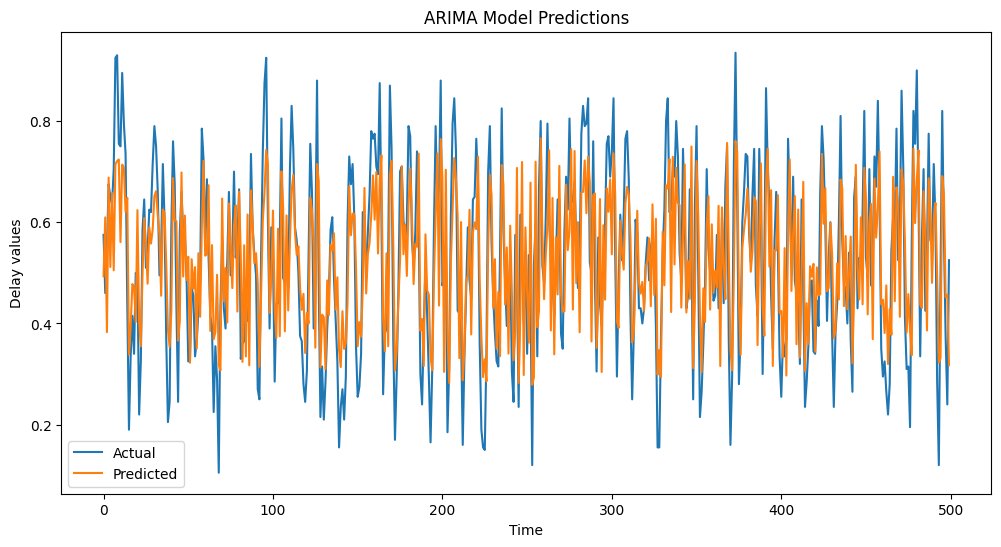

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test[:500], label='Actual')
plt.plot(predictions[:500], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Delay values')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

In [ ]:
# Define Dataset

node1_delay = df[['node2_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=200)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]

# Record the starting time to generate predictions
start_time = time.time()

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
    # estimate prediction error


# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (elapsed_time), "seconds")

Window Size:  9
17992 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.03787
ARIMA Test MAE : 0.03073
ARIMA Elapsed Time To generate Predictions : 390.82550 seconds


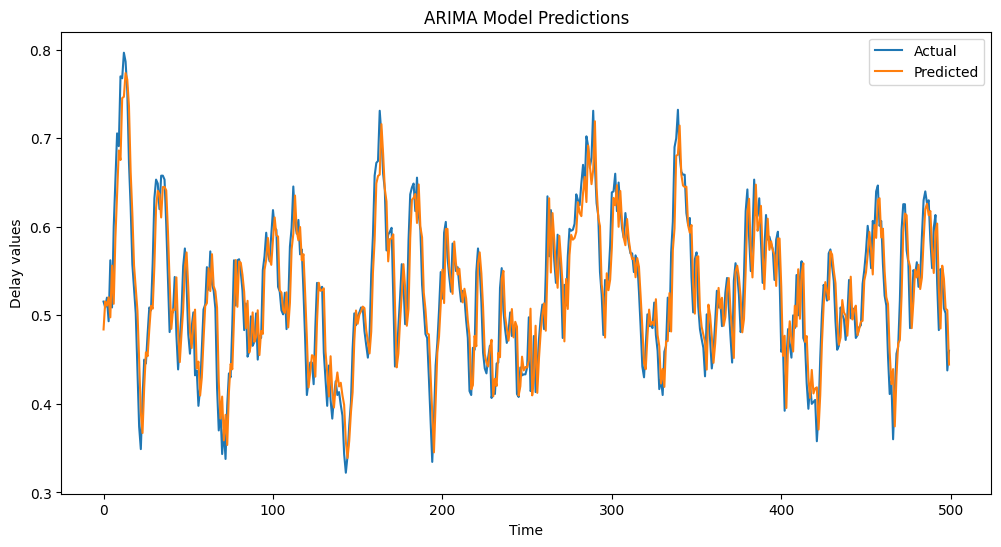

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test[:500], label='Actual')
plt.plot(predictions[:500], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Delay values')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

### LSTM Model

In [ ]:
# Best Params
look_back = 20 #100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 42 # 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node2_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=100)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  2
17999 2000
(17979, 1, 20)
Epoch 1/42


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


409/409 [==============================] - 14s 12ms/step - loss: 0.0392
Epoch 2/42
409/409 [==============================] - 4s 10ms/step - loss: 0.0210
Epoch 3/42
409/409 [==============================] - 5s 12ms/step - loss: 0.0194
Epoch 4/42
409/409 [==============================] - 5s 13ms/step - loss: 0.0187
Epoch 5/42
409/409 [==============================] - 5s 11ms/step - loss: 0.0184
Epoch 6/42
409/409 [==============================] - 5s 12ms/step - loss: 0.0182
Epoch 7/42
409/409 [==============================] - 4s 10ms/step - loss: 0.0181
Epoch 8/42
409/409 [==============================] - 4s 10ms/step - loss: 0.0180
Epoch 9/42
409/409 [==============================] - 5s 11ms/step - loss: 0.0177
Epoch 10/42
409/409 [==============================] - 5s 11ms/step - loss: 0.0177
Epoch 11/42
409/409 [==============================] - 4s 10ms/step - loss: 0.0174
Epoch 12/42
409/409 [==============================] - 5s 11ms/step - loss: 0.0175
Epoch 13/42
409/409 [==

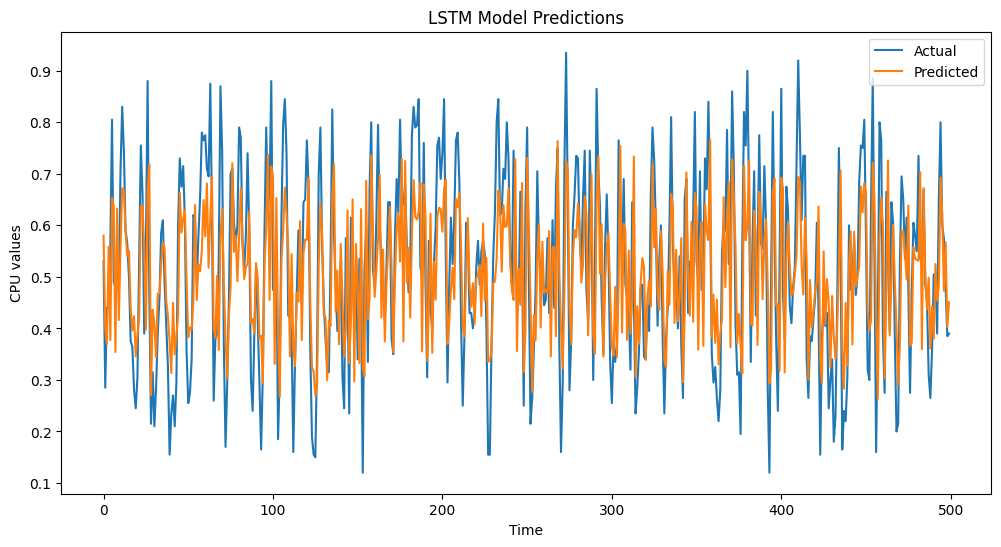

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(testY[:500], label='Actual')
plt.plot(testPredict[:500], label='Predicted')

plt.xlabel('Time')
plt.ylabel('CPU values')
plt.title('LSTM Model Predictions')
plt.legend()
plt.show()

### GRU Model

In [ ]:
# Best Params
look_back = 20 # 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 42
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node2_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=100)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  2
17999 2000
(17979, 1, 20)
Epoch 1/42


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


409/409 [==============================] - 14s 15ms/step - loss: 0.0325
Epoch 2/42
409/409 [==============================] - 4s 10ms/step - loss: 0.0196
Epoch 3/42
409/409 [==============================] - 4s 11ms/step - loss: 0.0187
Epoch 4/42
409/409 [==============================] - 5s 12ms/step - loss: 0.0182
Epoch 5/42
409/409 [==============================] - 4s 11ms/step - loss: 0.0180
Epoch 6/42
409/409 [==============================] - 5s 11ms/step - loss: 0.0178
Epoch 7/42
409/409 [==============================] - 5s 12ms/step - loss: 0.0178
Epoch 8/42
409/409 [==============================] - 4s 11ms/step - loss: 0.0178
Epoch 9/42
409/409 [==============================] - 5s 12ms/step - loss: 0.0175
Epoch 10/42
409/409 [==============================] - 5s 12ms/step - loss: 0.0176
Epoch 11/42
409/409 [==============================] - 4s 10ms/step - loss: 0.0173
Epoch 12/42
409/409 [==============================] - 5s 11ms/step - loss: 0.0174
Epoch 13/42
409/409 [==

### RNN Model

In [ ]:
# Best Params
look_back = 20 #100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 42
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node2_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=100)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  2
17999 2000
(17979, 1, 20)
Epoch 1/42


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


409/409 [==============================] - 4s 4ms/step - loss: 0.0365
Epoch 2/42
409/409 [==============================] - 1s 4ms/step - loss: 0.0195
Epoch 3/42
409/409 [==============================] - 1s 3ms/step - loss: 0.0188
Epoch 4/42
409/409 [==============================] - 2s 4ms/step - loss: 0.0183
Epoch 5/42
409/409 [==============================] - 1s 4ms/step - loss: 0.0181
Epoch 6/42
409/409 [==============================] - 2s 4ms/step - loss: 0.0181
Epoch 7/42
409/409 [==============================] - 2s 5ms/step - loss: 0.0182
Epoch 8/42
409/409 [==============================] - 3s 6ms/step - loss: 0.0179
Epoch 9/42
409/409 [==============================] - 2s 4ms/step - loss: 0.0177
Epoch 10/42
409/409 [==============================] - 1s 4ms/step - loss: 0.0179
Epoch 11/42
409/409 [==============================] - 2s 4ms/step - loss: 0.0175
Epoch 12/42
409/409 [==============================] - 1s 4ms/step - loss: 0.0176
Epoch 13/42
409/409 [===============

### ESN Model

In [ ]:
# Best params
# n_reservoir = 33
# sparsity = 0.3
# spectral_radius = 1.1
# noise = 0.004
# look_back = 261
n_reservoir = 13
sparsity = 0.5
spectral_radius = 1.25
noise = 0.002
look_back = 99

node1_delay = df[['node2_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=100)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  2
17999 2000
harvesting states...
fitting...
training error:
0.12597575580004516
ESN Model Training Elapsed Time : 1.36598 seconds
ESN Model Generate predictions Elapsed Time : 0.11125 seconds
ESN Test RMSE : 0.12613
ESN Test MAE : 0.10915


## Node3 CPU

### Persistence Model

In [ ]:
node1_delay = df[['node3_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, 1, 1)
testX, testY = create_multistep_dataset(test, 1, 1)

# Record the starting time to generate predictions
start_time = time.time()

predictions = testX[:,-1]

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

testRMSE = np.sqrt(mean_squared_error(testY, predictions))
testMAE = mean_absolute_error(testY, predictions)

print('Persistence Test RMSE : %.5f' % (testRMSE))
print('Persistence Test MAE : %.5f' % (testMAE))
print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  10
17991 2000
Persistence Test RMSE : 0.03505
Persistence Test MAE : 0.02852
Persistence Elapsed Time : 0.00009 seconds


### ARIMA Model

In [ ]:
# Define Dataset

node1_delay = df[['node3_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

predictions = []
cfg = ((1, 0, 1), (0, 0, 0, 0), 'c')
window_size = 285

# seed history with training dataset
history = [x for x in train]
total_training_elapsed_time, total_predictions_elapsed_time = [], []

# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat, training_elapsed_time, predictions_elapsed_time = sarima_forecast(history, cfg, window_size)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])

    total_training_elapsed_time.append(training_elapsed_time)
    total_predictions_elapsed_time.append(predictions_elapsed_time)


ARIMA_RMSE = measure_rmse(test, predictions)
ARIMA_MAE = measure_mae(test, predictions)

print('ARIMA Test RMSE : %.5f' % (ARIMA_RMSE))
print('ARIMA Test MAE : %.5f' % (ARIMA_MAE))

print("ARIMA Elapsed Time To train the model : %.5f" % (np.sum(total_training_elapsed_time)), "seconds")
print("ARIMA Elapsed Time To generate Predictions : %.5f" % (np.sum(total_predictions_elapsed_time)), "seconds")

print("ARIMA Mean Time To train the model : %.5f" % (np.mean(total_training_elapsed_time)), "seconds")
print("ARIMA Mean Time To generate Predictions : %.5f" % (np.mean(total_predictions_elapsed_time)), "seconds")

Window Size:  10
17991 2000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ARIMA Test RMSE : 0.03429
ARIMA Test MAE : 0.02791
ARIMA Elapsed Time To train the model : 262.20982 seconds
ARIMA Elapsed Time To generate Predictions : 5.62980 seconds
ARIMA Mean Time To train the model : 0.13110 seconds
ARIMA Mean Time To generate Predictions : 0.00281 seconds


### LSTM Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82 # 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node3_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 6s 5ms/step - loss: 0.0109
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0023
Epoch 3/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0018
Epoch 4/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0015
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 6/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 8/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 10/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0012
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 12/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 13/82
407/407 [===============

### GRU Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
gru_units_layer_0 = 15
gru_units_layer_1 = 32


node1_delay = df[['node3_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(GRU(units=gru_units_layer_0, return_sequences=True))
model.add(GRU(units=gru_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
GRU_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
GRU_MAE = mean_absolute_error(testY, testPredict)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("GRU Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('GRU Test RMSE : %.5f' % (GRU_RMSE))
print('GRU Test MAE : %.5f' % (GRU_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 5s 4ms/step - loss: 0.0100
Epoch 2/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0025
Epoch 3/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0016
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 5/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 6/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 7/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 8/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 9/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 11/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 12/82
407/407 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 13/82
407/407 [===============

### RNN Model

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
rnn_units_layer_0 = 15
rnn_units_layer_1 = 32


node1_delay = df[['node3_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(SimpleRNN(units=rnn_units_layer_0, return_sequences=True))
model.add(SimpleRNN(units=rnn_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
RNN_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
RNN_MAE = mean_absolute_error(testY, testPredict)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("RNN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('RNN Test RMSE : %.5f' % (RNN_RMSE))
print('RNN Test MAE : %.5f' % (RNN_MAE))

Window Size:  10
17991 2000
(17891, 1, 100)
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


407/407 [==============================] - 4s 7ms/step - loss: 0.0101
Epoch 2/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0032
Epoch 3/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0022
Epoch 4/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 5/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0017
Epoch 6/82
407/407 [==============================] - 3s 8ms/step - loss: 0.0016
Epoch 7/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 8/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 9/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 10/82
407/407 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 11/82
407/407 [==============================] - 3s 7ms/step - loss: 0.0013
Epoch 12/82
407/407 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 13/82
407/407 [===============

### ESN Model

In [ ]:
# Best params
n_reservoir = 33
sparsity = 0.3
spectral_radius = 1.1
noise = 0.004
look_back = 261

node1_delay = df[['node3_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# Build and fit the ESN model

model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
            )

# Record the starting time to training the model
training_start_time = time.time()

pred_train = model.fit(trainX, trainY)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

# Record the starting time to generate predictions
predictions_start_time = time.time()

predictions = model.predict(testX)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

predictions = np.array(predictions)

# calculate root mean squared error
ESN_RMSE = np.sqrt(mean_squared_error(testY, predictions))
ESN_MAE = mean_absolute_error(testY, predictions)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("ESN Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('ESN Test RMSE : %.5f' % (ESN_RMSE))
print('ESN Test MAE : %.5f' % (ESN_MAE))

Window Size:  10
17991 2000
harvesting states...
fitting...
training error:
0.025309971013166573
ESN Model Training Elapsed Time : 2.11508 seconds
ESN Model Generate predictions Elapsed Time : 0.14229 seconds
ESN Test RMSE : 0.02569
ESN Test MAE : 0.02209


# Confirm Our Hypothesis

In [ ]:
# Finding best params

node1_delay = df[['node2_cpu']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=100)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))


# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(temp_train, look_back, 1)
    validX, validY = create_multistep_dataset(valid, look_back, 1)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], validX.shape[1]))

    # Build and fit the ESN model

    model = ESN(n_inputs = look_back,
                n_outputs = 1,
                n_reservoir = n_reservoir,
                sparsity=sparsity,
                random_state=1234,
                spectral_radius=spectral_radius,
                noise = noise,
                teacher_scaling = 10)

    # Train and test our model
    pred_train = model.fit(trainX, trainY)
    predictions = model.predict(validX)
    predictions = np.array(predictions)

    # Evaluate the model on the validation set
    val_loss = np.sqrt(mean_squared_error(predictions, validY))

    return val_loss

# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("ESN HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-08-28 20:02:33,469] A new study created in memory with name: no-name-e413139c-4c17-4bfc-acb5-1d563936fcae


Window Size:  2
17999 16200 1799 2000


[I 2023-08-28 20:03:35,654] Trial 0 finished with value: 0.1303427207500915 and parameters: {'n_reservoir': 687, 'sparsity': 0.3, 'spectral_radius': 0.7, 'noise': 0.003, 'look_back': 461}. Best is trial 0 with value: 0.1303427207500915.
[I 2023-08-28 20:03:56,179] Trial 1 finished with value: 0.13166049393836315 and parameters: {'n_reservoir': 631, 'sparsity': 0.01, 'spectral_radius': 0.7, 'noise': 0.001, 'look_back': 74}. Best is trial 0 with value: 0.1303427207500915.
[I 2023-08-28 20:03:59,863] Trial 2 finished with value: 0.12814442501151324 and parameters: {'n_reservoir': 169, 'sparsity': 0.2, 'spectral_radius': 0.4, 'noise': 0.009, 'look_back': 57}. Best is trial 2 with value: 0.12814442501151324.
[I 2023-08-28 20:04:49,210] Trial 3 finished with value: 0.13083477787990477 and parameters: {'n_reservoir': 920, 'sparsity': 0.1, 'spectral_radius': 1.1, 'noise': 0.008, 'look_back': 229}. Best is trial 2 with value: 0.12814442501151324.
[I 2023-08-28 20:05:06,685] Trial 4 finished wit

done
ESN HyperParameters Tuning Elapsed Time : 521.06698 seconds
Best Parameters:  {'n_reservoir': 13, 'sparsity': 0.5, 'spectral_radius': 1.25, 'noise': 0.002, 'look_back': 99}
Best Loss:  0.12744864410350593
